In [55]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation, DataService  # type: ignore
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter1d
import warnings
warnings.filterwarnings('ignore')

In [56]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [57]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [ ]:
def factor(df):
    # ===== 第一部分：基础特征计算 =====
    # 计算主动买入量占比
    df['buy_ratio'] = df['taker_buy_volume'] / (df['volume'] + 1e-7)
    
    # 计算价格波动率
    price_change = df['close'].pct_change()
    volatility = price_change.ewm(span=96, min_periods=24).std()
    
    # 计算量价比率
    vp_ratio = df['volume'] / (volatility + 1e-7)
    
    # 关键周期定义
    periods = [96, 288, 672, 1440, 2880]
    
    # ===== 第二部分：多尺度量价背离检测 =====
    # 预计算动量指标
    price_momentums = [df['close'].pct_change(p) for p in periods]
    volume_momentums = [df['volume'].pct_change(p) for p in periods]
    flow_momentums = [df['buy_ratio'].diff(p) for p in periods]
    
    # 计算背离矩阵
    is_tail = (df['buy_ratio'] < 0.25).values
    divergence_matrix = np.zeros((len(df), len(periods)))
    
    for i in range(len(periods)):
        price_volume_div = (np.sign(price_momentums[i]) * np.sign(volume_momentums[i]) < 0)
        price_flow_div = (np.sign(price_momentums[i]) * np.sign(flow_momentums[i]) < 0)
        
        div_strength = (price_volume_div.astype(int) + price_flow_div.astype(int)) * np.abs(flow_momentums[i])
        div_strength = np.where(is_tail, div_strength * 2.0, div_strength)
        divergence_matrix[:, i] = div_strength
    
    # ===== 第三部分：特征矩阵构建 =====
    # 使用列表推导式替代column_stack
    vp_matrix = np.array([vp_ratio.ewm(span=p, min_periods=int(p/4)).mean() for p in periods]).T
    combined_matrix = np.hstack((vp_matrix, divergence_matrix))
    
    # ===== 第四部分：生存滚动标准化（优化核心）=====
    scaled_std = np.zeros_like(combined_matrix)
    n_cols = combined_matrix.shape[1]
    n_rows = len(df)
    
    # 预计算全局衰减权重
    decay_weights = np.exp(-np.arange(2880)/288)[::-1]  # 反转使最近的权重最大
    decay_weights /= decay_weights.sum()
    
    # 使用滑动窗口视图优化滚动计算
    window_size = 2880
    min_periods = 720
    
    # 为每列创建滑动窗口视图
    for col_idx in range(n_cols):
        col_data = combined_matrix[:, col_idx]
        rolling_q20 = np.full(n_rows, np.nan)
        rolling_q80 = np.full(n_rows, np.nan)
        
        # 从满足最小周期要求的点开始处理
        for i in range(min_periods - 1, n_rows):
            # 确定当前窗口范围
            start_idx = max(0, i - window_size + 1)
            end_idx = i + 1
            window_data = col_data[start_idx:end_idx]
            window_len = len(window_data)
            
            # 获取对应的权重片段
            weights_segment = decay_weights[-window_len:]
            
            # 计算加权分位数
            sorted_idx = np.argsort(window_data)
            sorted_vals = window_data[sorted_idx]
            sorted_weights = weights_segment[sorted_idx]
            cum_weights = np.cumsum(sorted_weights)
            total_weight = cum_weights[-1]
            
            # 找到20%和80%分位点
            q20_idx = np.searchsorted(cum_weights, 0.2 * total_weight)
            q80_idx = np.searchsorted(cum_weights, 0.8 * total_weight)
            
            rolling_q20[i] = sorted_vals[q20_idx] if q20_idx < window_len else sorted_vals[-1]
            rolling_q80[i] = sorted_vals[q80_idx] if q80_idx < window_len else sorted_vals[-1]
        
        # 应用标准化
        scaled_std[:, col_idx] = (col_data - rolling_q20) / (rolling_q80 - rolling_q20 + 1e-7)
    
    # ===== 第五部分：最终因子计算 =====
    tail_weight = np.where(df['buy_ratio'] < 0.25, 1.5, 1.0)
    factor_vals = np.mean(scaled_std, axis=1) * np.log1p(df['volume']) * df['buy_ratio'] * tail_weight
    
    # 去除超过6的因子值（设为np.nan）
    factor_vals = np.where(factor_vals > 6, np.nan, factor_vals)
    return factor_vals

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
📈 平稳性检验 (ADF):
   p_value: 0.000000
   是否平稳: 是
🔗 相关性分析:
   IC (Pearson): 0.013681
   Rank_IC (Spearman): 0.013761
📊 信息比率:
   IR: 1.040100
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 121589
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


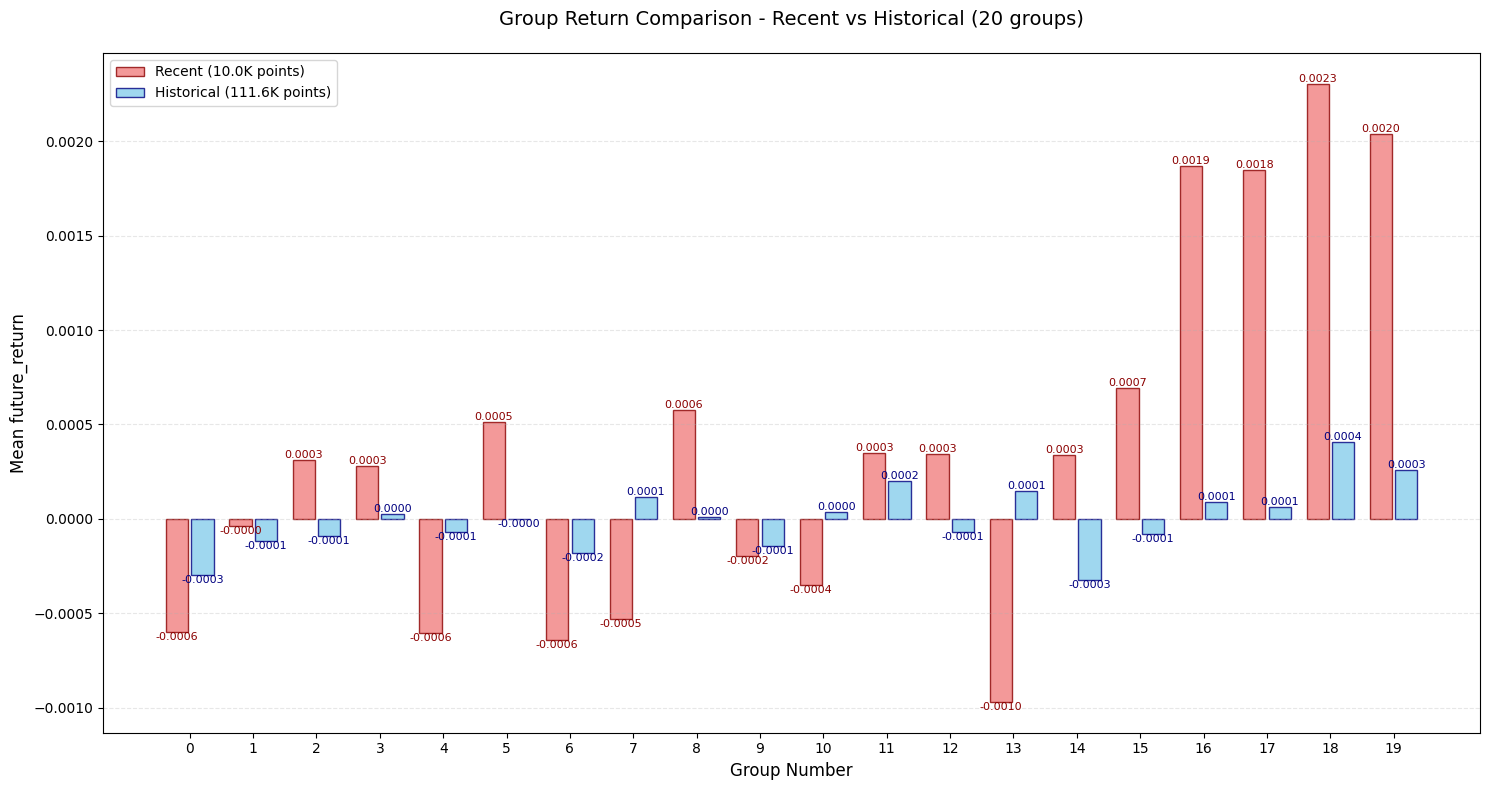

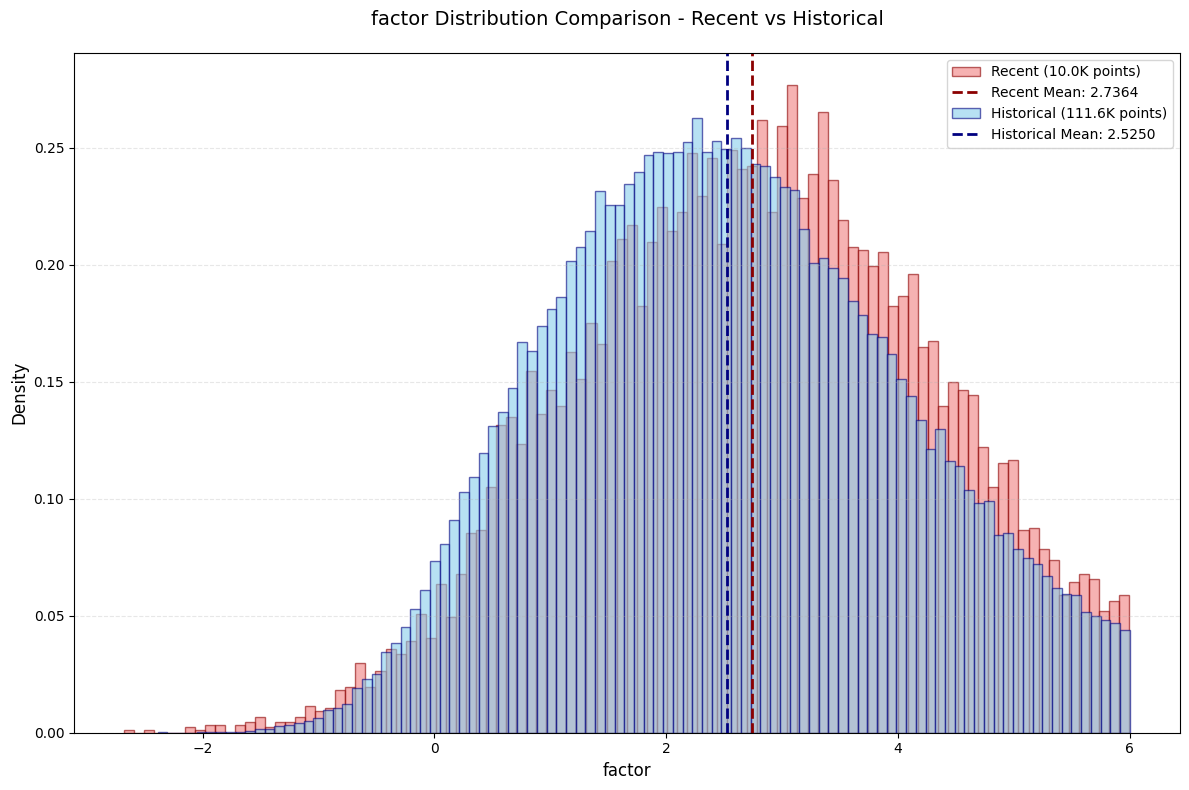

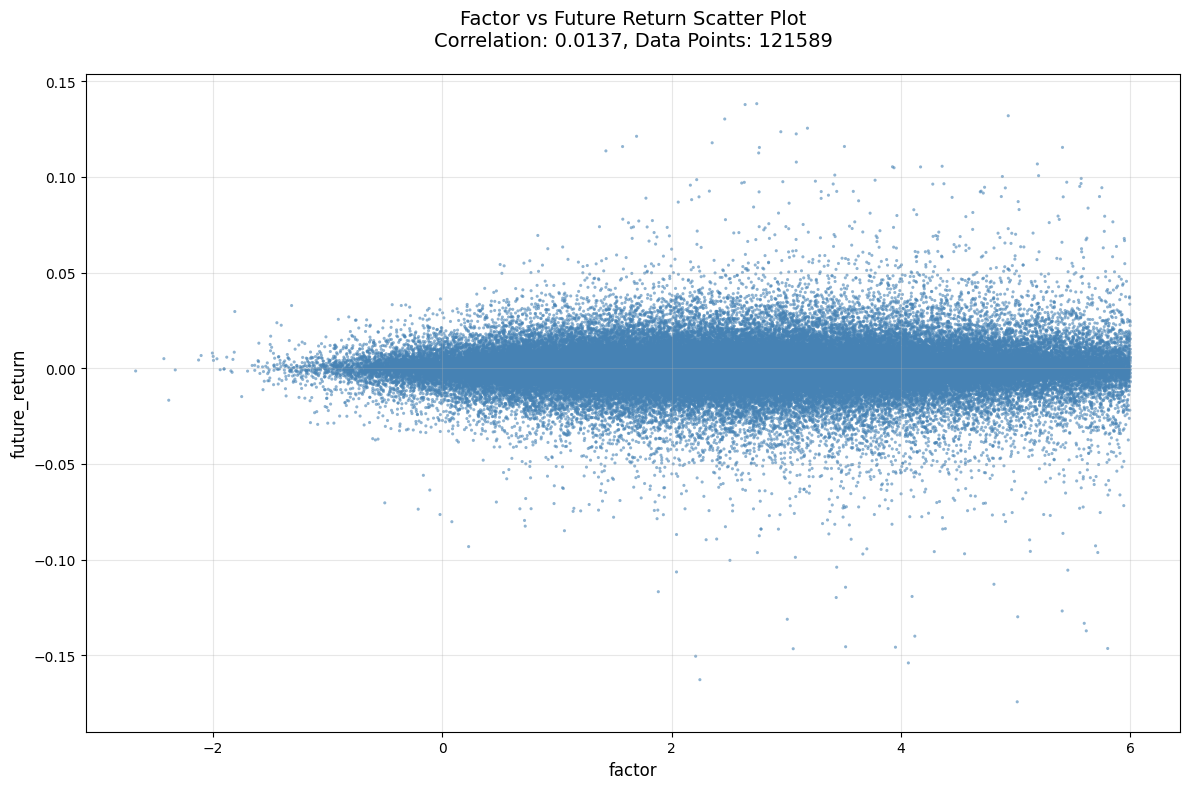

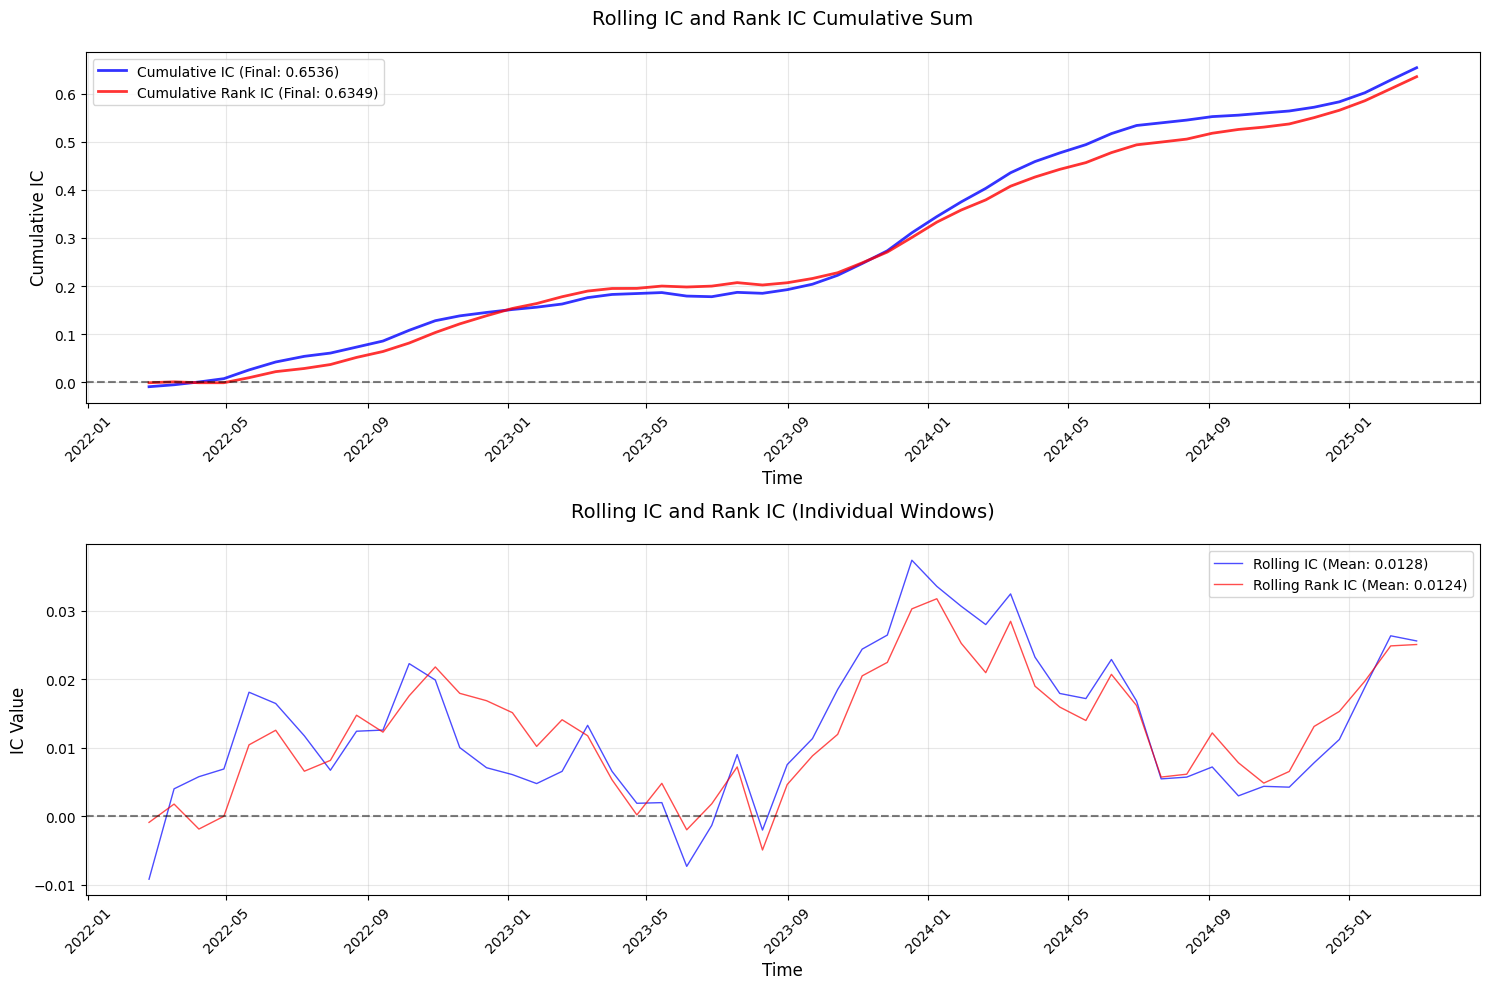

✅ 已显示 4 个图片
----------------------------------------


In [59]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=True)

In [60]:
from tabulate import tabulate

def display_factor_evaluation(result):
    # 1. 基础统计指标
    basic_metrics = [
        ["信息系数(IC)", result['correlation_analysis']['IC']],
        ["秩相关系数(Rank IC)", result['correlation_analysis']['Rank_IC']],
        ["信息比率(IR)", result['information_ratio']['IR']],
        ["分组数量", result['information_ratio']['n_groups']],
        ["数据点数", f"{result['factor_return_scatter']['data_points']:,}"],
        ["异常值(>3σ)", f"{result['factor_distribution']['outlier_analysis']['>3std']*100:.2f}%"],
        ["异常值(>5σ)", f"{result['factor_distribution']['outlier_analysis']['>5std']*100:.2f}%"]
    ]
    
    # 2. 分组分析
    group_stats = result['group_analysis']['group_stats']
    group_table = []
    for idx, row in group_stats.iterrows():
        group_table.append([
            idx,
            f"{row['val_min']:.4f}",
            f"{row['val_max']:.4f}",
            f"{row['val_mean']:.4f}",
            f"{row['return_mean']:.6f}",
            f"{row['return_std']:.4f}",
            row['count']
        ])
    
    # 3. 因子分布描述
    dist_stats = result['factor_distribution']['descriptive_stats']
    distribution_metrics = [
        ["均值", f"{dist_stats['mean']:.4f}"],
        ["标准差", f"{dist_stats['std']:.4f}"],
        ["最小值", f"{dist_stats['min']:.4f}"],
        ["1%分位数", f"{dist_stats['1%']:.4f}"],
        ["5%分位数", f"{dist_stats['5%']:.4f}"],
        ["25%分位数", f"{dist_stats['25%']:.4f}"],
        ["中位数", f"{dist_stats['50%']:.4f}"],
        ["75%分位数", f"{dist_stats['75%']:.4f}"],
        ["95%分位数", f"{dist_stats['95%']:.4f}"],
        ["99%分位数", f"{dist_stats['99%']:.4f}"],
        ["最大值", f"{dist_stats['max']:.4f}"]
    ]
    
    # 4. 分组相关性
    group_correlations = []
    for i, corr in enumerate(result['information_ratio']['group_correlations']):
        group_correlations.append([f"组 {i+1}", f"{corr:.6f}"])
    
    # 5. 滚动IC分析 - 完整展示
    rolling_ic = result['rolling_ic_analysis']['rolling_ic']
    rolling_rank_ic = result['rolling_ic_analysis']['rolling_rank_ic']
    window_centers = result['rolling_ic_analysis']['window_centers']
    cumsum_ic = result['rolling_ic_analysis']['cumsum_ic']
    cumsum_rank_ic = result['rolling_ic_analysis']['cumsum_rank_ic']
    
    # 创建滚动IC数据表格
    rolling_table = []
    for i in range(len(rolling_ic)):
        rolling_table.append([
            window_centers[i].strftime('%Y-%m-%d %H:%M:%S'),
            f"{rolling_ic[i]:.6f}",
            f"{rolling_rank_ic[i]:.6f}",
            f"{cumsum_ic[i]:.6f}",
            f"{cumsum_rank_ic[i]:.6f}"
        ])
    
    # 滚动IC汇总统计
    rolling_metrics = [
        ["滚动IC均值", f"{pd.Series(rolling_ic).mean():.6f}"],
        ["滚动IC标准差", f"{pd.Series(rolling_ic).std():.6f}"],
        ["滚动Rank IC均值", f"{pd.Series(rolling_rank_ic).mean():.6f}"],
        ["滚动Rank IC标准差", f"{pd.Series(rolling_rank_ic).std():.6f}"],
        ["累积IC终值", f"{cumsum_ic[-1]:.6f}"],
        ["累积Rank IC终值", f"{cumsum_rank_ic[-1]:.6f}"],
        ["初始窗口大小", result['rolling_ic_analysis']['initial_window']],
        ["滚动步长", result['rolling_ic_analysis']['rolling_step']]
    ]
    
    # 6. 时间窗口统计
    window_stats = []
    window_data = result['factor_distribution']['window_stats'][10]
    
    # 正确处理时间窗口统计数据
    if isinstance(window_data['stats'], pd.DataFrame):
        # 如果是DataFrame结构
        for idx, row in window_data['stats'].iterrows():
            window_stats.append([
                idx,
                f"{row['mean']:.4f}",
                f"{row['std']:.4f}",
                f"{row['skew']:.4f}",
                f"{row['lambda']:.4f}",
                row['count']
            ])
    else:
        # 如果是字典结构
        for time_range, stats in window_data['stats'].items():
            window_stats.append([
                time_range,
                f"{stats['mean']:.4f}",
                f"{stats['std']:.4f}",
                f"{stats['skew']:.4f}",
                f"{stats['lambda']:.4f}",
                stats['count']
            ])
    
    # # 7. 平稳性测试结果
    # stationarity = result['stationarity_test']
    # stationarity_metrics = [
    #     ["ADF统计量", stationarity['adf_statistic']],
    #     ["P值", stationarity['p_value']],
    #     ["1%临界值", stationarity['critical_values']['1%']],
    #     ["5%临界值", stationarity['critical_values']['5%']],
    #     ["10%临界值", stationarity['critical_values']['10%']],
    #     ["是否平稳", stationarity['is_stationary']],
    #     #["显著性水平", stationarity['alpha']]
    # ]
    
    # 打印所有结果
    print("="*80)
    print("因子评估核心指标".center(80))
    print("="*80)
    print(tabulate(basic_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    # print("\n" + "="*80)
    # print("平稳性测试结果".center(80))
    # print("="*80)
    # print(tabulate(stationarity_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("分组分析结果".center(80))
    print("="*80)
    print(tabulate(group_table, headers=["分组", "最小值", "最大值", "平均值", "收益均值", "收益标准差", "样本数"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("因子分布统计".center(80))
    print("="*80)
    print(tabulate(distribution_metrics, headers=["统计量", "值"], tablefmt="grid", floatfmt=".4f"))
    
    print("\n" + "="*80)
    print("分组相关性".center(80))
    print("="*80)
    print(tabulate(group_correlations, headers=["分组", "相关性"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("滚动IC分析汇总".center(80))
    print("="*80)
    print(tabulate(rolling_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("滚动IC详细数据".center(80))
    print("="*80)
    print(tabulate(rolling_table, headers=["窗口中心", "滚动IC", "滚动Rank IC", "累积IC", "累积Rank IC"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("时间窗口统计".center(80))
    print("="*80)
    print(tabulate(window_stats, headers=["时间窗口", "均值", "标准差", "偏度", "Lambda", "样本数"], tablefmt="grid"))
    print(f"时间范围: {window_data['time_ranges']}")

# 调用展示函数
display_factor_evaluation(result)

                                    因子评估核心指标                                    
+---------------------+----------------------+
| 指标                | 值                   |
+=====================+======================+
| 信息系数(IC)        | 0.013681243770279596 |
+---------------------+----------------------+
| 秩相关系数(Rank IC) | 0.01376064031179029  |
+---------------------+----------------------+
| 信息比率(IR)        | 1.0400995623232858   |
+---------------------+----------------------+
| 分组数量            | 10                   |
+---------------------+----------------------+
| 数据点数            | 121,589              |
+---------------------+----------------------+
| 异常值(>3σ)         | 11.79%               |
+---------------------+----------------------+
| 异常值(>5σ)         | 0.00%                |
+---------------------+----------------------+

                                     分组分析结果                                     
+--------+----------+----------+----------+------------+------------